In [1]:
import os
import pickle
import glob
import shap
import random
import numpy as np
import pandas as pd
from pathlib import Path

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Shap Analysis

In [2]:
experiment_path = "../OUTPUT/AMD"
outcome_label = 'conversion'
instance_label = None
algorithm = 'Extreme Gradient Boosting'

In [3]:
supported_algos = ['Extreme Gradient Boosting', 'Light Gradient Boosting', 
                   'Category Gradient Boosting', 'Decision Tree']
if algorithm not in supported_algos:
    raise Exception('Only Tree Based algorithms supported')

In [4]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)

# Name of experiment folder
experiment_name = experiment_path.split('/')[-1] 

datasets = os.listdir(experiment_path)
remove_list = ['.DS_Store', 'metadata.pickle', 'metadata.csv', 'algInfo.pickle',
                'DatasetComparisons', 'jobs', 'jobsCompleted', 'logs',
                'KeyFileCopy', 'dask_logs',
                experiment_name + '_ML_Pipeline_Report.pdf']
for text in remove_list:
    if text in datasets:
        datasets.remove(text)

datasets = sorted(datasets) # ensures consistent ordering of datasets
print("Analyzed Datasets: " + str(datasets))

Analyzed Datasets: ['AMD_Data_Final']


In [5]:
# Unpickle metadata from previous phase
file = open(experiment_path + '/' + "metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()
# Load variables specified earlier in the pipeline from metadata
outcome_label = metadata['Class Label']
instance_label = metadata['Instance Label']
cv_partitions = int(metadata['CV Partitions'])

# Unpickle algorithm information from previous phase
file = open(experiment_path + '/' + "algInfo.pickle", 'rb')
algInfo = pickle.load(file)
file.close()
algorithms = []
abbrevs = {}
for key in algInfo:
    if algInfo[key][0]: # If that algorithm was used
        algorithms.append(key)
        abbrevs[key] = (algInfo[key][1])

if algorithm not in algorithms:
    raise Exception('Given algorithm was not trained')

In [7]:
def run_plots(train_file_path, test_file_path, outcome_label="Class", instance_label=None, random_state=42):
    random.seed(random_state)
    np.random.seed(random_state)
    # Load training and testing datasets separating features from outcome for scikit-learn-based modeling
    train = pd.read_csv(train_file_path)
    test = pd.read_csv(test_file_path)
    if instance_label is not None:
        train = train.drop(instance_label, axis=1)
        test = test.drop(instance_label, axis=1)
    x_train = train.drop(outcome_label, axis=1).values
    y_train = train[outcome_label].values
    x_test = test.drop(outcome_label, axis=1).values
    y_test = test[outcome_label].values
    if 10000 < x_train.shape[0]:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=10000, random_state=random_state)
        for train_index, _ in sss.split(x_train, y_train):
            x_train = x_train[train_index]
            y_train = y_train[train_index]
        logging.warning('For ' + algorithm + ', training sample reduced to ' + str(x_train.shape[0]) + ' instances')
    
    model_info = full_path + '/models/pickledModels/' + abbrevs[algorithm] + '_' + str(cv_count) + '.pickle'
    # Corresponding pickle file name with scalingInfo
    infile = open(model_info, 'rb')
    model = pickle.load(infile)
    infile.close()

    #explaining model
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    #for each iteration we save the test_set index and the shap_values
    return shap_values, x_test

[13:08:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:08:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differenc

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


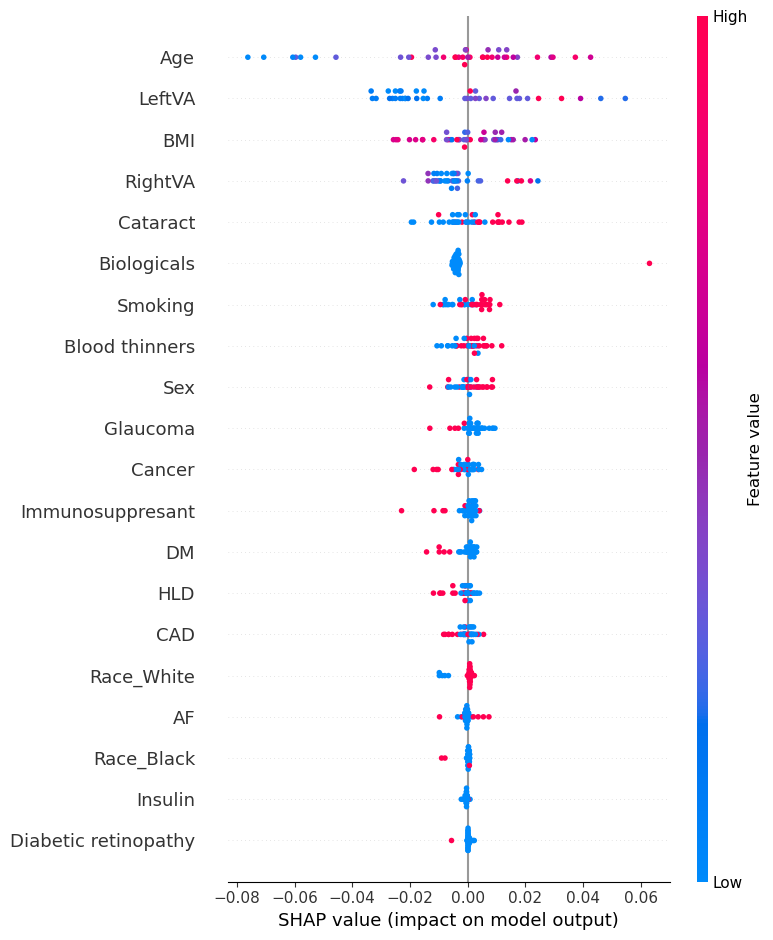

In [8]:
list_shap_values = list()
list_test_sets = list()
algorithms = [algorithm,]
for dataset_directory_path in datasets:
    full_path = experiment_path + "/" + dataset_directory_path
    cv_dataset_paths = list(glob.glob(full_path + "/CVDatasets/*_CV_*Train.csv"))
    cv_dataset_paths = [str(Path(cv_dataset_path)) for cv_dataset_path in cv_dataset_paths]
    cv_partitions = len(cv_dataset_paths)
    data_name = full_path.split('/')[-1]
    for cv_count in range(cv_partitions):
        for algorithm in algorithms:
            abbrev = abbrevs[algorithm]
            train_file_path = full_path + '/CVDatasets/' + data_name \
                               + '_CV_' + str(cv_count) + '_Train.csv'
            test_file_path = full_path + '/CVDatasets/' + data_name \
                              + '_CV_' + str(cv_count) + '_Test.csv'
            shap_values, x_test = run_plots(train_file_path, test_file_path, 
                                                outcome_label, instance_label, random_state=42)
#     print(shap_values.shape)
    list_shap_values.append(shap_values)
    list_test_sets.append(x_test)
    
columns = list(pd.read_csv(train_file_path).columns)
columns.remove(outcome_label)
if instance_label is not None:
    columns.remove(instance_label)
test_set = np.array(list_test_sets[0])
shap_values = np.array(list_shap_values[0])
for i in range(1,len(list_test_sets)):
    test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)
#bringing back variable names    
X_test = pd.DataFrame(test_set, columns=columns)

#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
if 'Extreme Gradient Boosting' in algorithms:
    shap.summary_plot(shap_values, X_test)
else:
    shap.summary_plot(shap_values[0], X_test)